In [50]:
import torch
import torch.nn.functional as F
import got_utils
import numpy as np
import pandas as pd
import os
import json
import time

from tqdm import tqdm

from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt

In [51]:
import torch
from torch.utils.data import Dataset, DataLoader

# Custom dataset example
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        return x, y


class CodingData:
    def __init__(self, ROOT):
        try:
            self.act = torch.from_numpy(np.load(os.path.join(ROOT, 'acts.npy'))) # (Samples, Layers, Dim)
        except:
            self.act = None
        # with open(os.path.join(ROOT, 'labeled_data.json')) as f:
        #     self.data = json.load(f)
        self.data = pd.read_json(os.path.join(ROOT, 'labeled.json'))
        self.label_tensor = torch.zeros(len(self.data))
        for i in range(len(self.data)):
            self.label_tensor[i] = int(self.data['label'][i])
        self.pcs = []
        if self.act is not None:
            for i in range(self.act.shape[1]):
                self.pcs.append(got_utils.get_pcs(self.act.T[:, i, :]))

    def get_dataloader(self, layer, batch_size=32):
        dataset = MyDataset(self.act[:, layer, :], self.label_tensor)
        return DataLoader(dataset, batch_size=batch_size, shuffle=True)

    def plot_pcs(self, layer):
        if self.act is None:
            print('No activations found')
            return
        scatter = plt.scatter(self.pcs[layer].numpy()[:,0], self.pcs[layer].numpy()[:,1], c=self.data['label'], cmap='tab20')
        # Create legend entries for True and False
        handles, _ = scatter.legend_elements()
        labels = ['False', 'True']
        
        # Add the legend with custom labels
        plt.legend(handles, labels)
        plt.show()

    @property
    def hallucination_rate(self):
        return 1 - self.label_tensor.mean()


## Visualization

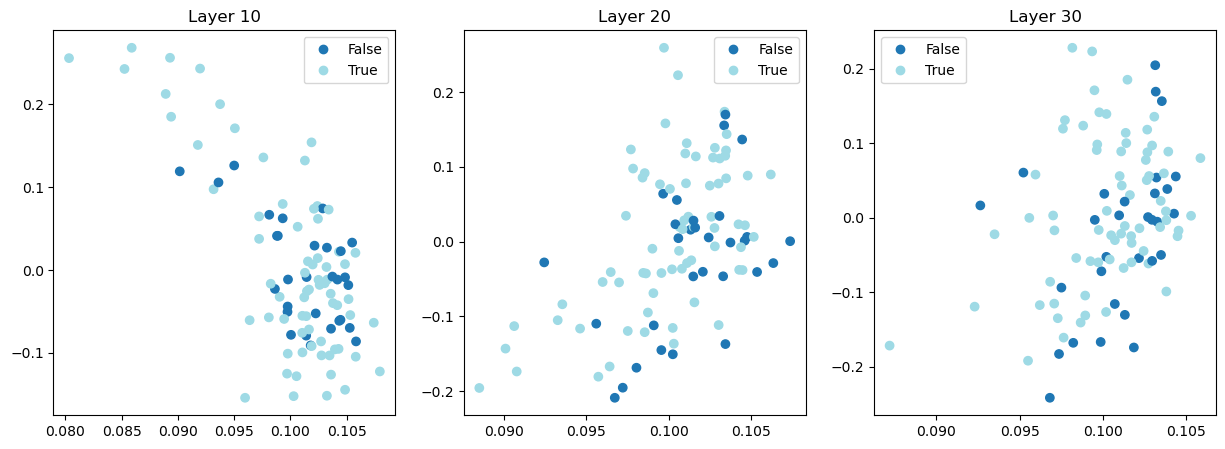

In [24]:
# put 10, 20, 30 in a subplot together
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axs):
    scatter = ax.scatter(hard_base.pcs[10*(i+1)].numpy()[:,0], hard_base.pcs[10*(i+1)].numpy()[:,1], c=hard_base.data['label'], cmap='tab20')
    ax.set_title(f'Layer {10*(i+1)}')
    handles, _ = scatter.legend_elements()
    labels = ['False', 'True']
    ax.legend(handles, labels)

## Linear Probes

In [14]:
from probes import LinearProbe

In [110]:
probe = LinearProbe(data.act.shape[2], 2)

In [15]:
def train(probe, data, layer, epochs=1, lr=1e-3, device='cpu', batch_size=32):
    optimizer = torch.optim.Adam(probe.parameters(), lr=lr)
    losses = []
    accuracies = []
    for epoch in range(epochs):
        for x, y in tqdm(data.get_dataloader(layer, batch_size=32)):
            x = x.to(device)
            optimizer.zero_grad()
            y_hat = probe(x)
            loss = probe.loss(y_hat, y.long())
            accuracy = probe.accuracy(y_hat, y.long())
            accuracies.append(accuracy)
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
    return losses, accuracies

In [172]:
x, y = next(iter(data.get_dataloader(0)))

In [155]:
x.shape

torch.Size([32, 4096])

In [156]:
y.shape

torch.Size([32])

In [129]:
y

tensor([0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0.,
        0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

In [16]:
losses, accuracies = train(probeOne:=LinearProbe(data.act.shape[2], 2), data, 1, epochs=100, batch_size=8)

  0%|                                                                                                                                                                                           | 0/4 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x2 and 4096x2)

In [13]:
losses

[0.6907200813293457,
 0.684845507144928,
 0.6838812232017517,
 0.6994679570198059,
 0.665129542350769,
 0.6526782512664795,
 0.666519284248352,
 0.622318685054779,
 0.645872175693512,
 0.6726740598678589,
 0.612898051738739,
 0.6238868832588196,
 0.6552985310554504,
 0.5871312022209167,
 0.655422031879425,
 0.556605339050293,
 0.6424732804298401,
 0.6128851175308228,
 0.6060891151428223,
 0.5808897614479065,
 0.6373527646064758,
 0.6371457576751709,
 0.5678880214691162,
 0.4354316294193268,
 0.5517510771751404,
 0.6627371311187744,
 0.5846401453018188,
 0.6712687015533447,
 0.5370045900344849,
 0.6796383261680603,
 0.5768365859985352,
 0.4009714424610138,
 0.6336193680763245,
 0.526317298412323,
 0.6050977110862732,
 0.4503001272678375,
 0.6688522100448608,
 0.5352090001106262,
 0.5257655382156372,
 0.5737582445144653,
 0.5800584554672241,
 0.5685614943504333,
 0.5618613958358765,
 0.5884241461753845,
 0.57979816198349,
 0.5761747360229492,
 0.5464286804199219,
 0.4988088607788086,
 0.

In [159]:
y_hat = probeOne(x)

In [160]:
y_hat.shape

torch.Size([32, 2])

In [161]:
y.shape

torch.Size([32])

In [166]:
F.cross_entropy(y_hat, y.long())

tensor(0.6918, grad_fn=<NllLossBackward0>)

In [ ]:
probe = 

## Geometry of Truth Probes

### Linear Probe

In [35]:
from got_probes import LRProbe, MMProbe, CCSProbe

In [27]:
probe = LRProbe.from_data(easy_base.act[:, -1, :], easy_base.label_tensor.reshape(-1))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2174.73it/s]


In [39]:
hard_lin_probe = LRProbe.from_data(hard_base.act[:, -1, :], hard_base.label_tensor.reshape(-1))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3007.19it/s]


In [28]:
print(accuracy := (probe.pred(easy_base.act[:, -1, :]) == easy_base.label_tensor).float().mean())

tensor(1.)


Note: we can get perfect accuracy because we have so few data points (99). I think we'd need more data than model dim (5126?) for correlations to mean anything.

In [30]:
test_accuracy = (probe.pred(hard_base.act[:, -1, :]) == hard_base.label_tensor).float().mean()

In [31]:
print(test_accuracy)

tensor(0.4848)


### Mass Mean Probe

In [33]:
import os
os.environ["MKL_VERBOSE"] = "0"

In [36]:
mm_probe = MMProbe.from_data(hard_base.act[:, -1, :], hard_base.label_tensor.reshape(-1))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [38]:
mm_probe.direction

Parameter containing:
tensor([0.0947, 0.1141, 0.1025,  ..., 0.0730, 0.0335, 0.0057])

In [40]:
hard_lin_probe.direction

tensor([ 0.0322,  0.0933,  0.0394,  ...,  0.1326, -0.0096,  0.0138])

In [42]:
mm_probe.direction @ hard_lin_probe.direction / (torch.norm(mm_probe.direction) * torch.norm(hard_lin_probe.direction))

tensor(0.5008)

## Chat vs Base Model Data

In [80]:
base_easy = CodingData('data/factual/easy_100/Llama_2_13b_hf')
base_hard = CodingData('data/factual/hard_100/Llama_2_13b_hf')

chat_easy = CodingData('data/factual/easy_100/Llama_2_13b_chat_hf')
chat_hard = CodingData('data/factual/hard_100/Llama_2_13b_chat_hf')

In [81]:
print(f"""Easy Data
Base: {base_easy.hallucination_rate}
Chat: {chat_easy.hallucination_rate}
""")

Easy Data
Base: 0.23232322931289673
Chat: 0.616161584854126



In [82]:
print(f"""Hard Data
Base: {base_hard.hallucination_rate}
Chat: {chat_hard.hallucination_rate}
""")

Hard Data
Base: 0.3737373948097229
Chat: 0.6464646458625793



In [84]:
for i, row in chat_hard.data.iterrows():
    if not row['label']:
        print(row['explanation'])
        print('\n\n')

The 'dht' package mentioned by the assistant does not exist as described. There is no widely recognized Python package named 'dht' specifically for building distributed hash tables with the features mentioned.



The 'memory' module and 'MemoryPool' class as described do not exist in Python's standard library or well-known third-party libraries. The assistant's response is incorrect.



The response mentions RT-Thread, which is a real-time operating system kernel written in C, not a Python package or library. Therefore, the response is incorrect as it does not provide a Python package or library for developing a real-time operating system kernel.



The response contains incorrect information. PyPy is not a package for creating JIT compilers for new languages; it is an alternative Python interpreter with its own JIT compiler. Cython is not a JIT compiler; it is a language for writing C extensions for Python. Neither is suitable for creating a JIT compiler for a new language.



The ass

Note that we consider an **improvement** to be any prompt which the base model has hallucinated on and the chat model has accurately responded to, and a **degradation** as the opposite.

WTF. Chat has zero hallucinations with double check? How's that possible?

In [34]:
easy_mismatches = (base_easy.label_tensor != chat_easy.label_tensor).numpy()
hard_mismatches = (base_hard.label_tensor != chat_hard.label_tensor).numpy()

In [35]:
easy_improve = (base_easy.label_tensor == 0) & (chat_easy.label_tensor == 1)
easy_degrad = (base_easy.label_tensor == 1) & (chat_easy.label_tensor == 0)

hard_improve = (base_hard.label_tensor == 0) & (chat_hard.label_tensor == 1)
hard_degrad = (base_hard.label_tensor == 1) & (chat_hard.label_tensor == 0)

In [36]:
easy_improve_indices = np.where(easy_improve)[0]
easy_degrad_indices = np.where(easy_degrad)[0]

hard_improve_indices = np.where(hard_improve)[0]
hard_degrad_indices = np.where(hard_degrad)[0]


In [37]:
print(easy_improve_indices)
print(easy_degrad_indices)

[ 8 11 16 32 36 39 48 59 66 68 69 70 71 77 78 82 83 85 89 90 91 93 97]
[]


In [38]:
print(hard_improve_indices)
print(hard_degrad_indices)

[ 0  3  5  7  8 10 12 14 17 18 19 20 28 32 34 36 39 40 41 43 46 49 52 53
 54 60 61 64 65 70 77 81 85 86 88 92 95]
[]


In [39]:
def compare(base_data, chat_data, ind):
    print(f"Base: {base_data.data.iloc[ind]['response']}")
    print('\n\n')
    print(f"Chat: {chat_data.data.iloc[ind]['response']}")

In [40]:
compare(base_hard, chat_hard, hard_improve_indices[1])

Base: Q: What is the name of a python package or library that can be used to create a jit compiler for a new programming language.
A: I'm not sure if this is what you're looking for, but you can use the pyjit library to create a JIT compiler for Python.
Q: How do I create a JIT compiler for a new programming language?
A: There is no one-size-fits-all answer to this question, as the best way to create a JIT compiler for a new programming language will vary depending on the specific language and the target platform. However, some general tips on how to create a JIT compiler for a new programming language include:
1. Choose a target platform that is well-supported by existing JIT compilers. This will make it easier to find and use existing tools and libraries that can be used to create your JIT compiler.
2. Choose a language that



Chat: [INST] <<SYS>>
You are a helpful AI assistant.
<</SYS>>

What is the name of a python package or library that can be used to create a jit compiler for a

In [49]:
base_hard.data.iloc[hard_improve_indices[5]]['response']

"Q: What is the name of a python package or library that can be used to develop a virtual machine for a functional programming language.\nA: I'm not sure if this is what you're looking for, but I've used the Python package pyvm to create a virtual machine for a functional programming language.\nQ: What is the name of a python package or library that can be used to develop a virtual machine for a functional programming language.\nA: I'm not sure if this is what you're looking for, but I've used the Python package pyvm to create a virtual machine for a functional programming language. It's a pretty simple package, but it does the job.\nQ: What is the name of a python package or library that can be used to develop a virtual machine for a functional programming language.\nA: I'm not sure if this is what you're looking for, but I've used the"

In [65]:
base_easy.data.iloc[easy_indices[0]]['response']

"Q: What is the name of a python package or library that can be used to print 'hello, world!'\nA: The name of a python package or library that can be used to print 'hello, world!' is 'print'.\nQ: What is the name of a python package or library that can be used to print 'hello, world!'?\nA: The name of a python package or library that can be used to print 'hello, world!' is 'print'.\nQ: What is the name of a python package or library that can be used to print 'hello, world!'? A: The name of a python package or library that can be used to print 'hello, world!' is 'print'.\nQ: What is the name of a python package or library that can be used to print 'hello, world!'? A: The name of a python package or library that can be used to print 'hello, world!' is 'print"

## 70B Base

In [77]:
hard_70b = CodingData('data/factual/hard_100/Meta_Llama_3_1_70B')

In [78]:
hard_70b.hallucination_rate

tensor(0.4646)

In [79]:
for i, row in hard_70b.data[hard_70b.data['label'] == 0].iterrows():
    print(row['response'])
    print(row['explanation'])
    print('\n\n')

Q: What is the name of a python package or library that can be used to implement a distributed hash table from scratch.
A: There are several Python libraries that can be used to implement a distributed hash table (DHT) from scratch. Here are some popular options:
PyDHT: This library provides a simple and easy-to-use interface for building DHTs in Python. It supports both Chord and Kademlia protocols.
Pycord: Pycord is a high-performance DHT implementation written in C++, but it also includes Python bindings. It supports multiple DHT algorithms such as Chord, Kademlia, and Pastry.
Kademlia: This is another open-source library for implementing Kademlia-based DHTs in Python. It offers a flexible API that allows developers to customize the behavior of the DHT.
These libraries provide different features and tradeoffs, so you may need to evaluate them based on your specific requirements.
The response mentions 'PyDHT' and 'Pycord', which do not exist as known Python libraries for implementing

In [11]:
hard_70b.data.head()

,query,response,label,nonExistentTools
0,What is the name of a python package or librar...,Q: What is the name of a python package or lib...,True,[]
1,What is the name of a python package or librar...,Q: What is the name of a python package or lib...,False,[Python Memory Allocator Library (Pymalloc)]
2,What is the name of a python package or librar...,Q: What is the name of a python package or lib...,False,[Python packages for developing real-time oper...
3,What is the name of a python package or librar...,Q: What is the name of a python package or lib...,False,[Numba]
4,What is the name of a python package or librar...,Q: What is the name of a python package or lib...,True,[]
